# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# Restart kernel after this
#!pip310 install .

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. One continuous action between [-1 and 1] corresponding to the speed approaching toward/retreating from the net, and one binary action corresponding to jumping, are available.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
SKIP_RANDOM = True

states_hist = np.zeros((1,24))

if not SKIP_RANDOM:

    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            # actions = np.random.rand(num_agents, action_size)*2-1   # All actions are between -1 and 1
            actions = [[0,0],[0,0]]
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            if i==1:
                states_hist = np.vstack((states_hist, next_states[1,:]))
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        # print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
        print(scores)

### 4. Train with Deep Deterministic Policy Gradient (DDPG)

Given that this game is collaborative in nature, fully deterministic and has a mixed continuous/binary action space, DDPG seems like a sensible candidate. A single shared weight is used for both agents.

In [7]:
from collections import deque
import torch
from learner.ddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Hyperparameters

REPLAY_BUFFER_SIZE = int(1e6)   # replay buffer size
REPLAY_BATCH_SIZE = int(50)     # minibatch size
FUTURE_DISCOUNT = 0.99          # discount factor
SOFT_UPDATE_RATE = 1e-3         # soft update rate
LR_ACTOR = 1e-4                 # learning rate of the actor 
LR_CRITIC = 3e-4                # learning rate of the critic
WEIGHT_DECAY = 0.0              # L2 weight decay
UPDATE_FREQ = 1                 # Learn frequency in iterations
UPDATE_EVERY = True             # If true, learn once for every agent

USE_TWO_MEMS = False            # Whether to separately sample good vs bad experiences
BAD_MEM_RATIO = 0.5
UNIFORM_SAMPLE_MIN_SCORE = 50   # Minimum score above which we revert to sampling good and bad experiences uniformly

ADD_NOISE = True                # Whether to add OU noise
NOISE_SIGMA_START = 4           # Start of the OU noise random walk magnitude
NOISE_SIGMA_DECAY = 0.9999      # Decay rate of the OU random walk
NOISE_SIGMA_MIN = 0.01          # Minimum of the OU random walk

N_EPISODES = 1250
VICTORY_SCORE = 0.5

Episode 100	Average Score: 0.015	Score: 0.000
Episode 200	Average Score: 0.010	Score: 0.000
Episode 300	Average Score: 0.017	Score: 0.000
Episode 400	Average Score: 0.022	Score: 0.000
Episode 500	Average Score: 0.026	Score: 0.000
Episode 600	Average Score: 0.025	Score: 0.000
Episode 700	Average Score: 0.042	Score: 0.000
Episode 800	Average Score: 0.049	Score: 0.100
Episode 900	Average Score: 0.067	Score: 0.000
Episode 1000	Average Score: 0.099	Score: 0.100
Episode 1100	Average Score: 0.188	Score: 0.290
Episode 1177	Average Score: 0.519	Score: 2.700
Environment solved in 1077 episodes!	Average Score: 0.519
Episode 1200	Average Score: 0.691	Score: 0.100
Episode 1249	Average Score: 1.183	Score: 2.600

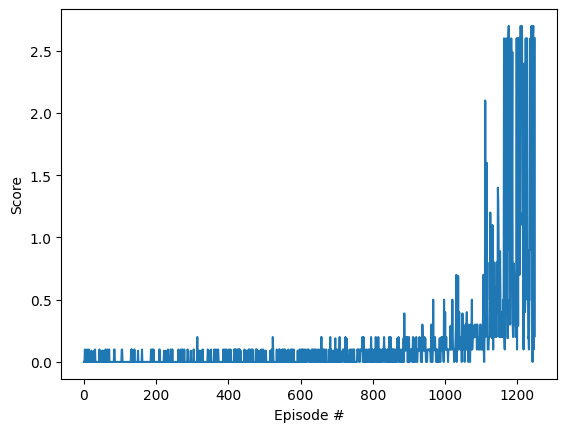

In [9]:
agent = Agent(state_size, action_size, random_seed=42, 
              replay_buffer_size=REPLAY_BUFFER_SIZE, replay_batch_size=REPLAY_BATCH_SIZE, future_discount=FUTURE_DISCOUNT, soft_update_rate=SOFT_UPDATE_RATE, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, add_noise=ADD_NOISE, use_two_mems=USE_TWO_MEMS, bad_mem_ratio=BAD_MEM_RATIO)

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
uniform_sampling = False
noise_sigma = NOISE_SIGMA_START
solved = False
count = 0
training = True

for i_episode in range(1,N_EPISODES):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    total_rewards = np.zeros(num_agents)

    # Reset noise
    agent.reset()

    while True:
        # Get agent's action per policy
        actions = agent.act(states, noise_sigma)

        # Noise helps with exploration, but needs to decay
        noise_sigma = max(NOISE_SIGMA_MIN, noise_sigma*NOISE_SIGMA_DECAY)

        # Apply agent's action to env
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations     # get the next state
        rewards = env_info.rewards                     # get the reward
        dones = env_info.local_done                    # see if episode has finished

        # Agent remembers and learns
        # Only learn once per 2 time steps
        count = (count + 1) % UPDATE_FREQ
        for i in range(num_agents):
            perform_learn = (count == 0) and (UPDATE_EVERY or i>=num_agents-1)
            agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], perform_learn, uniform_sampling)

        states = next_states
        total_rewards += rewards

        if np.any(dones):
            break    
    
    max_total_reward = np.max(total_rewards)
    scores_window.append(max_total_reward)       # save most recent score
    scores.append(max_total_reward)              # save most recent score
    mean_score = np.mean(scores_window)

    print('\rEpisode {}\tAverage Score: {:.3f}\tScore: {:.3f}'.format(i_episode, mean_score, max_total_reward), end="")

    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, mean_score))

    if mean_score >= VICTORY_SCORE and not solved:
        solved = True
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, mean_score))
        torch.save(agent.actor_local.state_dict(), 'trained_weights/solved_actor.pt')
        torch.save(agent.critic_local.state_dict(), 'trained_weights/solved_critic.pt')

    # Latch uniform sampling once score has reached certain threshold
    uniform_sampling = np.mean(scores_window) >= UNIFORM_SAMPLE_MIN_SCORE or uniform_sampling

torch.save(agent.actor_local.state_dict(), 'trained_weights/termination_actor.pt')
torch.save(agent.critic_local.state_dict(), 'trained_weights/termination_critic.pt')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('plots/Scores.png')

env.close()

### 4. Watch the Smart Agent

Restart kernel if running this right after training to reload Unity.

In [1]:
from unityagents import UnityEnvironment
from learner.ddpg_agent import Agent
import numpy as np
import torch

if 'training' not in vars() or not training:

    env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe', no_graphics=False, worker_id = 100, seed = 70)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations

    num_agents = len(env_info.agents)
    action_size = brain.vector_action_space_size
    state_size = states.shape[1]
    agent = Agent(state_size, action_size, add_noise=False)
    agent.actor_local.load_state_dict(torch.load('trained_weights/termination_actor.pt'))
    agent.critic_local.load_state_dict(torch.load('trained_weights/termination_critic.pt'))

    total_rewards = np.zeros(num_agents)
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        dones = env_info.local_done
        total_rewards += env_info.rewards
        if np.any(dones):
            break 
                
    print('\rScore: {:.2f}'.format(np.max(total_rewards)))
    env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
W:\Temp\ipykernel_3908\2995614565.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

Score: 2.60
